In [204]:
import pandas as pd
#pulls stock market information
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

#use date as its own datatype
from datetime import date,timedelta

import datetime as dt
#tensorflow is what im building the models and training them from
#these are the ML packages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

#these are specific AI models for our predictive algorithm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [2]:
df = pd.read_csv("Cramers Picks (2016 to 2022) Performance v2.csv")

In [3]:
#filtering the data
df["Date"] = pd.to_datetime(df["Date"])
df["Call"] = df["Call"].replace("Buy", 4)
df["Call"] = df["Call"].replace("Sell", 0)
df["Call"] = df["Call"].replace("Positive Mention", 3)
df["Call"] = df["Call"].replace("Negative Mention", 1)
df["Call"] = df["Call"].replace("Hold", 2)
#i convert everything into a standard date format then put it back into a string 
#honestly cant say much reason why
df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")
df

C:\Users\adams\AppData\Local\Temp\ipykernel_53312\1230903150.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"])


,S.No,Company,Ticker,Date,Call,1-Day Change Recommendation,1-Week Change Recommendation,1-Month Change Recommendation,1-Year Change Recommendation,1-Day Change Benchmark,1-Week Change Benchmark,1-Month Change Benchmark,1-Year Change Benchmark
0,1,Lululemon Athletica,LULU,2018-03-27,3,2.0%,2.7%,15.4%,95%,-0.4%,1.4%,3%,10%
1,2,Penn National Gaming,PENN,2020-07-14,4,10.3%,4.4%,52.5%,100%,-0.2%,1.6%,5%,37%
2,3,Simon Property Group,SPG,2020-11-13,4,-1.2%,8.2%,10.6%,121%,0.4%,-1.4%,1%,31%
3,4,PVH Corp,PVH,2016-05-25,4,-2.5%,3.8%,-9.4%,13%,0.0%,0.7%,-4%,18%
4,5,Broadcom,AVGO,2016-06-02,3,-1.9%,-1.1%,-7.0%,58%,0.0%,-0.1%,0%,18%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21649,21650,Not Available,F,2022-11-22,1,0.2%,-0.9%,-19.0%,NaN,NaN,NaN,NaN,NaN
21650,21651,Not Available,EL,2022-11-22,4,-0.1%,6.2%,8.6%,NaN,NaN,NaN,NaN,NaN
21651,21652,Not Available,SHOP,2022-11-22,3,4.0%,11.2%,-8.3%,NaN,NaN,NaN,NaN,NaN
21652,21653,Not Available,IMGN,2022-11-22,1,-3.2%,0.6%,-9.7%,NaN,NaN,NaN,NaN,NaN


In [4]:
stocks = {}
#creating a dictionary to hold the information we pull from 

In [5]:
#this function matches data from yahoo finance and our dataset
def JimOverTime(tick):
    #downloading data from yfinancec
    stocks[tick] = yf.download(tick, period="max", interval="1d")
    #filtering the data 
    stocks[tick]["date"] = stocks[tick].index
    stocks[tick]["index"] = range(len(stocks[tick]))
    pd.to_datetime(stocks[tick]["date"])
    stocks[tick].set_index("index")
    stocks[tick].index = pd.to_datetime(stocks[tick].index)
    stocks[tick]["date"]=stocks[tick]["date"].dt.date
    stocks[tick]["date"] = pd.to_datetime(stocks[tick]["date"])
    stocks[tick]["date"].tz_localize(None)
    stocks[tick]["date"] = stocks[tick]["date"].dt.strftime("%Y-%m-%d")
    #most of this filtering is done very poorly as i really dont know how to or like using datetime

    #setting up my lists that will later be turned into a dataframe
    date = []
    call = []
    price = []
    volume = []

    #using datetime format to make a range of dates to gather data from
    date = pd.date_range(start=pd.to_datetime('2016-01-01'), end=pd.to_datetime('2023-01-01'), freq='D')
    date = date.strftime("%Y-%m-%d")

    date = list(date)
    #matching our dataset dates to our yahoo dates
    #once match append information from our dataset to the yahoo set
    for i in date:
        if i in list(df[df["Ticker"] == tick]["Date"]):
            price.append(stocks[tick][stocks[tick]["date"] == i]["Close"].to_numpy())
            volume.append(stocks[tick][stocks[tick]["date"] == i]["Volume"].to_numpy())
            call.append(df.loc[(df["Ticker"] == tick) & (df["Date"] == i)]["Call"].to_numpy())
        else:
            call.append(None)
            price.append(stocks[tick][stocks[tick]["date"] == i]["Close"].to_numpy())
            volume.append(stocks[tick][stocks[tick]["date"] == i]["Volume"].to_numpy())

    #create dataframe
    _df = {"date": date,
           "price": price,
           "volume": volume,
           "call": call}
    _df = pd.DataFrame(_df)
    _df = _df[_df["price"] != 0]
    return _df


In [6]:
#this function takes our data and plots it
#we plot the price with jim cramers calls as well as the volume of the stock
def jimOverTimePlot(df): 
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(pd.to_datetime(df["date"]),df["price"],label="Price")
    plt.scatter(pd.to_datetime(df.dropna()["date"]),df.dropna()["price"],c=df.dropna()["call"])
    plt.subplot(1, 2, 2)
    plt.plot(pd.to_datetime(df["date"]),df["volume"],label="Volume")
    plt.show()


In [7]:
dfS = JimOverTime("UAL")


[*********************100%***********************]  1 of 1 completed


In [8]:
dfS

,date,price,volume,call
3,2016-01-04,[[55.61000061035156]],[[5693200]],None
4,2016-01-05,[[55.060001373291016]],[[6982900]],None
5,2016-01-06,[[55.20000076293945]],[[4902100]],None
6,2016-01-07,[[52.630001068115234]],[[6095600]],None
7,2016-01-08,[[51.88999938964844]],[[6365600]],None
...,...,...,...,...
2548,2022-12-23,[[38.38999938964844]],[[4262500]],None
2552,2022-12-27,[[38.20000076293945]],[[6654000]],None
2553,2022-12-28,[[37.290000915527344]],[[6402600]],None
2554,2022-12-29,[[37.91999816894531]],[[5890600]],None


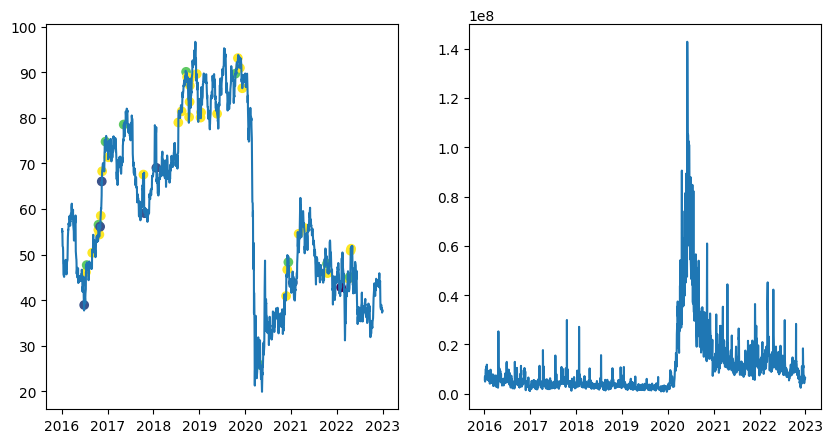

In [9]:
jimOverTimePlot(dfS)

In [117]:
#here we are scaling our variables on a range from 0-1
#ML models prefer to work with numbers in this range 
scaler = MinMaxScaler(feature_range=(0,1))
dfS['price'] = scaler.fit_transform(np.expand_dims(dfS['price'].values, axis=1))
dfS['volume'] = scaler.fit_transform(np.expand_dims(dfS['volume'].values, axis=1))
dfS['call'] = scaler.fit_transform(np.expand_dims(dfS['call'].values,axis=1))
dfS

,date,price,volume,call
3,2016-01-04,0.464835,0.034652,NaN
4,2016-01-05,0.457671,0.043732,NaN
5,2016-01-06,0.459495,0.029083,NaN
6,2016-01-07,0.426022,0.037485,NaN
7,2016-01-08,0.416384,0.039386,NaN
...,...,...,...,...
2548,2022-12-23,0.240557,0.024580,NaN
2552,2022-12-27,0.238083,0.041417,NaN
2553,2022-12-28,0.226231,0.039647,NaN
2554,2022-12-29,0.234436,0.036042,NaN


In [181]:
#i am replacing all not a number (NaN) values with 0
features = dfS[["price","call","volume"]]
features.fillna(0,inplace=True)        

C:\Users\adams\AppData\Local\Temp\ipykernel_53312\96889751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0,inplace=True)


In [182]:
#here I am reshaping our data to fit what the LSTM model uses for input
# a type of deep neural network that can process and predict sequential data, such as speech, text, and time series
#it wants a 3D array with columns sequence, steps, and features.
#this code puts our 3 features into one array in order to meet the 3D requirement 

def preprocess_lstm(seq,n_steps,n_features):
    
    x,y, = list(),list()
    for i in range(len(seq)):
        #find end of pattern
        end_ix = i + n_steps
        #check if beyond seq
        if end_ix >= len(seq):
            break
        #gather input and output parts of pattern
        seq_x, seq_y = seq[i:end_ix], seq[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    x = np.array(x)
    y = np.array(y)
    
    x = x.reshape((x.shape[0],x.shape[1],n_features))
    return x,y

In [183]:
#this is describing how many days and features we will be using to make predictions
nDays = 60
n_features = 3
x,y = preprocess_lstm(features.to_numpy(),nDays,n_features)




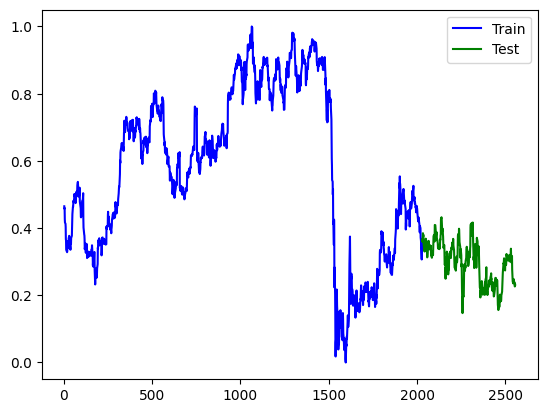

In [184]:
#here we are splitting our gathered data into a training set and a testing set
#we feed our training set into the ML model and keep it blind to the testing set
#once trained, we compare the model's predictions to our testing data to measure our accuracy
#we are reserving one year to make our predictions
test_days = 365

x_train,y_train = x[:-test_days,:],y[:-test_days,:]
x_test,y_test = x[-test_days:],y[-test_days:]

train_orig = dfS["price"].iloc[:-test_days]
test_orig = dfS["price"].iloc[-test_days:]

#here we are plotting the split 
plt.plot(train_orig,c="b",label="Train")
plt.plot(test_orig,c="g",label = "Test")
plt.legend()
plt.show()

In [185]:
#implementing vanila LSTM
#single hidden layer of LSTM unit and one output layer used to make predictions
#im down to use a different model if this works
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50,input_shape=(nDays,n_features)))
    model.add(Dense(1))
    return model


In [186]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=[tf.keras.metrics.MeanAbsoluteError()])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10800     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [187]:
#ran into datatype errors so here I am ensuring that each value is the correct datatype
x_train = x_train.astype("float32")
y_train = y_train.astype('float32')
x_test = x_test.astype("float32")
y_test = y_test.astype('float32')


In [188]:
#here we are giving the model we initiated the training data
#epochs are how many times the model is going through our entire dataset
#batch size is how many samples its going through at a time
model.fit(x_train,
          y_train,
          epochs=15,
          batch_size=32)    

Epoch 1/15
42/42 [==============================] - 2s 14ms/step - loss: 0.1073 - mean_absolute_error: 0.2680
Epoch 2/15
42/42 [==============================] - 1s 15ms/step - loss: 0.0934 - mean_absolute_error: 0.2675
Epoch 3/15
42/42 [==============================] - 1s 16ms/step - loss: 0.0932 - mean_absolute_error: 0.2664
Epoch 4/15
42/42 [==============================] - 1s 16ms/step - loss: 0.0931 - mean_absolute_error: 0.2663
Epoch 5/15
42/42 [==============================] - 1s 17ms/step - loss: 0.0931 - mean_absolute_error: 0.2661
Epoch 6/15
42/42 [==============================] - 1s 17ms/step - loss: 0.0930 - mean_absolute_error: 0.2660
Epoch 7/15
42/42 [==============================] - 1s 17ms/step - loss: 0.0930 - mean_absolute_error: 0.2658
Epoch 8/15
42/42 [==============================] - 1s 16ms/step - loss: 0.0930 - mean_absolute_error: 0.2659
Epoch 9/15
42/42 [==============================] - 1s 18ms/step - loss: 0.0930 - mean_absolute_error: 0.2664
Epoch 10/1

In [189]:
#we are evaluating our model using mean square error
#our error is fairly high.

print("evaluate on test Data")
results = model.evaluate(x_test,y_test,batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])


evaluate on test Data
12/12 [==============================] - 1s 7ms/step - loss: 0.0207 - mean_absolute_error: 0.1245
Test MSE: 0.020659087225794792
Test MAE: 0.12451354414224625


In [193]:
#now that we have a trained model we can make predictions 
#prediction
y_pred = model.predict(x_test)
#create a df from ypred to have date time index
pred_data = pd.DataFrame(y_pred[:,0],test_orig.index,columns=["price"])
#apply inverse transformation from 1.d

pred_data["price"] = pred_data["price"] + dfS["price"].shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


12/12 [==============================] - 0s 6ms/step


In [201]:
#the predicted data has a very good shape, however it is shifted up by a significant amount
#this probably means i just scaled something wrong 
#here i kinda just bs fixing the issue by shifting the output down by an arbitrary amount
scaler.fit_transform(pred_data)
pred_data -= .95

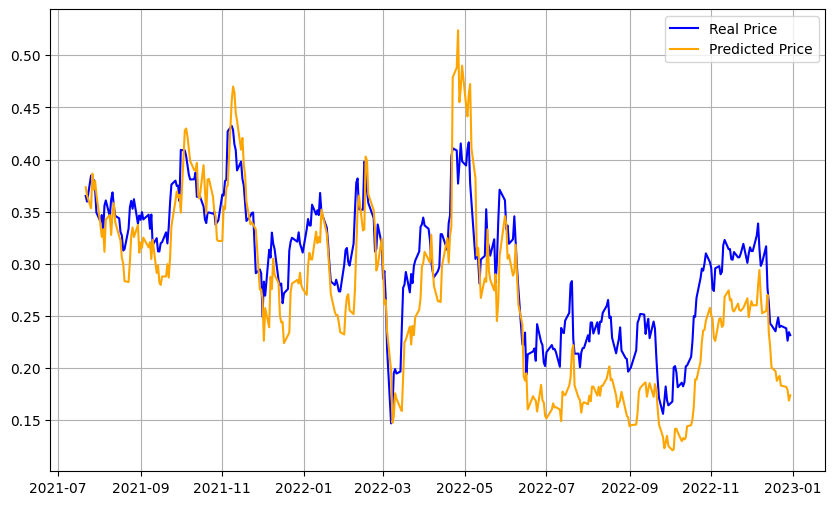

In [202]:
#plotting our predicted against our test data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(pd.to_datetime(dfS["date"].iloc[-test_days:]),test_orig,'b',label="Real Price")
plt.plot(pd.to_datetime(dfS["date"].iloc[-test_days:]),pred_data,'orange',label='Predicted Price')
plt.legend()
plt.show()

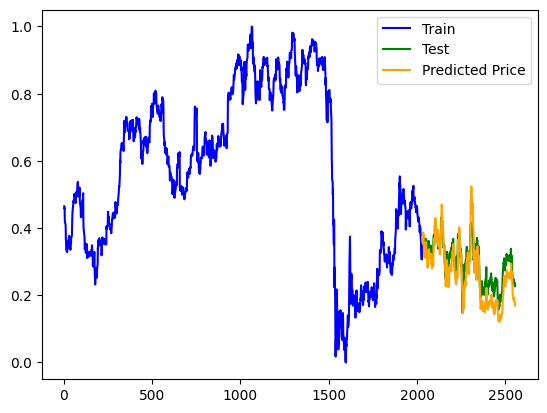

In [203]:
plt.plot(train_orig,c="b",label="Train")
plt.plot(test_orig,c="g",label = "Test")
plt.plot(pred_data,'orange',label='Predicted Price')

plt.legend()
plt.show()
